# Figure 5

This notebook contains the functions used to construct the figure 5 in the paper. 

The figure contains 2 panels:

- a) Decrease of exonic mutation burden, decreased non-synonymous mutation burden and exonic mutation rate decreased when compared to introns in tumors grouped by the underlying mutational processes.
- b) Decrease of exonic mutation burden of individual samples for all the tumor types analyzed.

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pybedtools
from os import path
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests as mlpt

from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
config_plot_params()

## Input

### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *clusters_file*: clusters of samples per tumor type
- *intron_coords*: file with the coordinates of the introns  
- *middle_exons_coords*: file with the coordinates of the middle exons
- *exons_coords*: file with the coordinates of all exons (not only middle) of genes with at least 5 exons

### Not included files

These files are not included. There is more information about them in the ``README`` file located in the **non_provided_data** folder.

- mutations_folder: base directory where the files with the mutations are located

### Other

- tumor_types_list: list of tumor types to be analysed

---

In addition to the mentioned input, this notebook used the files generated by the **signature_probability** and **gene_and_sample_analysis** notebooks.

In [5]:
# Included
clusters_file = 'data/clusters.tsv'
intron_coords = 'data/coordinates/genes_intron_coords.bed.gz'
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'
exons_coords = 'data/coordinates/gene_exon_coords_filtered.bed'

# Not included
mutations_folder = 'non_provided_data/mutations/'

# Other
tumor_types_list = ['bMMRD', 'blca', 'brca', 'crc', 'luad', 'lusc', 'skcm', 'ucec', 'eyelid']

## Mutation rate

Differences in mutation rate between centered exons and introns.

This process is explained in the **Exon to intron mutation rate** section.

In [6]:
middle_distance_threshold = 20
nucleotides = set(['A', 'T', 'C', 'G'])

exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", header=None, low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']


introns_coords_df = pd.read_csv(intron_coords, sep="\t", header=None, low_memory=False)
introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'symbol', 'strand']
introns_coords_df = introns_coords_df[['chr', 'start', 'end', 'ensembl']]
introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']

# Get only genes in exons and introns files
genes_list = list(set(exons_coords_df['ensembl'].tolist()).intersection(set(introns_coords_df['ensembl'].tolist())))
genes_list = genes_list

exons_coords_df = exons_coords_df[exons_coords_df['ensembl'].isin(genes_list)]
introns_coords_df = introns_coords_df[introns_coords_df['ensembl'].isin(genes_list)]

exons_coords_symbol_df = exons_coords_df
introns_coords_symbol_df = introns_coords_df

exons_bed = pybedtools.BedTool.from_dataframe(exons_coords_symbol_df)
introns_bed = pybedtools.BedTool.from_dataframe(introns_coords_symbol_df)

all_ttypes_results_lol = list()

clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)

sub_clusters_df = clusters_df[['sample_id', 'annotation']]
sub_clusters_df.columns = ['sample', 'annotation']

#Iterate tumor types and clusters
for tumor_type in tumor_types_list:
    
    for my_cluster in set(clusters_df[clusters_df['ctype'] == tumor_type]['cluster']):

        #Get mutatiosn in exons and introns
        mutations_file = path.join(mutations_folder, '{}.bed.gz'.format(tumor_type))
        mutations_df = pd.read_csv(mutations_file, sep="\t", header=None) 
        mutations_df.columns = ['CHROMOSOME', 'START', 'POSITION', 'REF', 'ALT', 'SAMPLE', 'TYPE']
        mutations_df = mutations_df[mutations_df['TYPE'] == 'subs']
        samples_ttype = list(set(mutations_df['SAMPLE'].tolist()))

        all_signatures = pd.read_csv(path.join('results', 'signatures.txt'), sep='\t')

        ttype_clusters_df = clusters_df[clusters_df['ctype'] == tumor_type]

        final_results_lol = list()

        cluster_samples = ttype_clusters_df[ttype_clusters_df['cluster'] == my_cluster]['sample_id'].tolist()
        cluster_mutations_df = mutations_df[mutations_df['SAMPLE'].isin(cluster_samples)]

        sub_mutations_df = cluster_mutations_df[['CHROMOSOME', 'POSITION', 'SAMPLE']].copy()
        sub_mutations_df['START'] = sub_mutations_df['POSITION'] - 1

        sub_mutations_df = sub_mutations_df[['CHROMOSOME', 'START', 'POSITION', 'SAMPLE']]

        sub_mutations_df.columns = ['chr', 'start', 'end', 'sample']

        sub_mutations_bed = pybedtools.BedTool.from_dataframe(sub_mutations_df)

        mutations_in_exons_bed = exons_bed.intersect(sub_mutations_bed, wao=True)
        mutations_in_introns_bed = introns_bed.intersect(sub_mutations_bed, wao=True)

        mutations_in_exons_symbol_df = pd.read_table(mutations_in_exons_bed.fn, names = ['chr_region',
                                               'start_region', 'end_region', 'gene', 'chr_mut',
                                                'start_mut', 'end_mut', 'sample', 'overlap_size'])

        mutations_in_introns_symbol_df = pd.read_table(mutations_in_introns_bed.fn, names = ['chr_region',
                                                       'start_region', 'end_region', 'gene', 'chr_mut',
                                                        'start_mut', 'end_mut', 'sample', 'overlap_size'])                               

        all_muts_symbol_df = pd.concat([mutations_in_exons_symbol_df, mutations_in_introns_symbol_df])
        all_muts_symbol_df = all_muts_symbol_df[all_muts_symbol_df['overlap_size'] != 0]
        all_muts_symbol_df = all_muts_symbol_df[['chr_mut', 'start_mut', 'end_mut', 'sample']]

        #Introns analysis
        
        #Define introns center and count mutations in a 41bp from the middle
        introns_central_result_lol = list()
        introns_coords_symbol_df = introns_coords_df.copy()

        introns_coords_symbol_df['intron_size'] = (introns_coords_symbol_df['end']
                                                    - introns_coords_symbol_df['start'])
        introns_coords_symbol_df['intron_middle_start'] = (introns_coords_symbol_df['start']
                                                     + introns_coords_symbol_df['intron_size']/2)
        introns_coords_symbol_df['intron_middle_start'] = introns_coords_symbol_df.apply(lambda x:
                                                                           math.floor(x['intron_middle_start']),
                                                                           axis=1)
        introns_coords_symbol_df['intron_middle_end'] = introns_coords_symbol_df['intron_middle_start'] + 1

        introns_coords_symbol_df['region_start'] = introns_coords_symbol_df['intron_middle_start'] - middle_distance_threshold
        introns_coords_symbol_df['region_end'] = introns_coords_symbol_df['intron_middle_end'] + middle_distance_threshold

        sub_introns_coords = introns_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                              'intron_size', 'intron_middle_start',
                                              'intron_middle_end']]

        sub_introns_coords_bed = pybedtools.BedTool.from_dataframe(sub_introns_coords)

        my_bed = sub_introns_coords_bed.intersect(sub_mutations_bed, wao=True)
        mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                                'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                                'mut_chr', 'mut_start', 'mut_end', 'sample', 'overlap_bp'])

        mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
        introns_muts = sum(mutations_in_range['overlap_bp'])
        introns_rate = introns_muts/len(sub_introns_coords)

        #Define exons center and count mutations in a 41bp from the middle
        exons_central_result_lol = list()
        exons_coords_symbol_df = exons_coords_df.copy()
        exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end']
                                                    - exons_coords_symbol_df['start'])
        exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start']
                                                     + exons_coords_symbol_df['exon_size']/2)
        exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                                           math.floor(x['exon_middle_start']),
                                                                           axis=1)
        exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1
        exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
        exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold
        sub_exons_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                              'exon_size', 'exon_middle_start',
                                              'exon_middle_end']]
        sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(sub_exons_coords)
        my_bed = sub_exons_coords_bed.intersect(sub_mutations_bed, wao=True)
        mutations_in_range = pd.read_table(my_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                                'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                                'mut_chr', 'mut_start', 'mut_end', 'sample', 'overlap_bp'])

        mutations_in_range = mutations_in_range[mutations_in_range['overlap_bp'] != 0]
        exons_muts = sum(mutations_in_range['overlap_bp'])

        exons_rate = exons_muts/len(sub_exons_coords)
        my_row = [tumor_type, my_cluster, exons_muts, len(sub_exons_coords),
                  exons_rate, introns_muts, len(sub_introns_coords), introns_rate]
        all_ttypes_results_lol.append(my_row)
        
        print(my_row)

all_ttypes_results_df = pd.DataFrame(all_ttypes_results_lol)
all_ttypes_results_df.columns = ['tumor_type', 'cluster', 'exon_muts', 'n_exons',
                                 'exons_rate', 'intron_muts', 'n_introns', 'introns_rate']

all_ttypes_results_df['ttype_cluster'] = (all_ttypes_results_df['tumor_type']
                                     + ' ' + all_ttypes_results_df['cluster'])

all_ttypes_results_df['log2fc_exon_intron'] = np.log2(all_ttypes_results_df['exons_rate']
                                                      /all_ttypes_results_df['introns_rate']) 

all_ttypes_results_df['total_muts'] = (all_ttypes_results_df['exon_muts']
                                       + all_ttypes_results_df['intron_muts'])

#filtered_results = all_ttypes_results_df[all_ttypes_results_df['total_muts'] > 500]

filtered_results = all_ttypes_results_df.sort_values(by='log2fc_exon_intron')

filtered_results.to_csv(path.join('results', 'mut_rate_exons_introns.tsv'), sep='\t', header=True, index=None)

['bMMRD', 'clusterB', 2989, 95164, 0.031408936152326511, 3944, 130555, 0.030209490253150013]
['bMMRD', 'clusterA', 2092, 95164, 0.021983102854020428, 2224, 130555, 0.017034966106238749]
['blca', 'clusterB', 60, 95164, 0.00063049052162582493, 80, 130555, 0.00061276856497261695]
['blca', 'clusterA', 333, 95164, 0.003499222395023328, 482, 130555, 0.0036919306039600169]
['brca', 'clusterC', 0, 95164, 0.0, 2, 130555, 1.5319214124315423e-05]
['brca', 'clusterD', 217, 95164, 0.0022802740532133999, 320, 130555, 0.0024510742598904678]
['brca', 'clusterA', 194, 95164, 0.0020385860199235006, 321, 130555, 0.0024587338669526254]
['brca', 'clusterE', 66, 95164, 0.00069353957378840737, 108, 130555, 0.00082723756271303284]
['brca', 'clusterB', 8, 95164, 8.4065402883443325e-05, 23, 130555, 0.00017617096242962736]
['crc', 'clusterB', 603, 95164, 0.0063364297423395399, 769, 130555, 0.0058902378307992796]
['crc', 'clusterC', 208, 95164, 0.0021857004749695264, 367, 130555, 0.0028110757918118801]
['crc', 'c

/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:153: RuntimeWarning: divide by zero encountered in log2


## Decrease

Compute the decreased exonic mutation rate and the decreased non synonymous mutations

In [7]:
def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """likelihood ratio test"""
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N #probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob #expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1) #log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0) #log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1) #chi2 score to pvalue
    
    return my_p

In [8]:
sample_level_results = list()

clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)
sub_clusters_df = clusters_df[['sample_id', 'annotation']]
sub_clusters_df.columns = ['sample', 'annotation']

#Iterate tumor types and clusters and load precomputed results
for ttype in tumor_types_list:
    print(ttype)

    for cluster_id in set(clusters_df[clusters_df['ctype'] == ttype]['cluster']):
        print(cluster_id)
        
        gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (ttype, cluster_id))  # Output from other notebook
        sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (ttype, cluster_id))  # Output from other notebook

        genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
        samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')
        
        my_genes =  genelvl_results_df['ensembl'].tolist()
        print(len(my_genes))
        samples_list = list(set(samplelvl_results_df['sample'].tolist()))

        products_sum_df = genelvl_results_df
        
        #For each sample, get number of observed and expected mutations in exons
        #Also, get the number of observed and expected non-synonymous mutations
        for my_sample in samples_list:
            sub_samplelvl_results_df = samplelvl_results_df[samplelvl_results_df['sample'] == my_sample]

            sub_samplelvl_results_df.columns = ['ensembl', 'obs_exon_muts', 'obs_intron_muts',
                                                'obs_syn_muts', 'obs_nonsyn_muts', 'sample']

            merged_sub_results = pd.merge(sub_samplelvl_results_df, products_sum_df, on='ensembl')

            merged_sub_results['exons_prob'] = merged_sub_results['exons_products_sum']/(merged_sub_results['exons_products_sum']+merged_sub_results['introns_products_sum'])
            merged_sub_results['introns_prob'] = merged_sub_results['introns_products_sum']/(merged_sub_results['exons_products_sum']+merged_sub_results['introns_products_sum'])
            merged_sub_results['total_muts'] = merged_sub_results['obs_exon_muts']+merged_sub_results['obs_intron_muts']

            merged_sub_results['exp_exon_muts'] = merged_sub_results['total_muts']*merged_sub_results['exons_prob']
            merged_sub_results['exp_intron_muts'] = merged_sub_results['total_muts']*merged_sub_results['introns_prob']

            n_obs_muts = merged_sub_results['obs_exon_muts'].sum()
            n_exp_muts = merged_sub_results['exp_exon_muts'].sum()

            n_intron_muts = merged_sub_results['obs_intron_muts'].sum()
            n_exp_intron_muts = merged_sub_results['exp_intron_muts'].sum()
            
            try:
                exons_decrease_over_expected = -(n_exp_muts-n_obs_muts)/n_exp_muts*100 
                
            except:
                exons_decrease_over_expected = np.nan

            total_muts = (n_obs_muts+n_intron_muts)
            
            exp_exon_prob = n_exp_muts/(n_obs_muts+n_intron_muts)
            
            my_exin_p = compute_pval(n_obs_muts, n_intron_muts, exp_exon_prob)

            #Syn - nonsyn mutations
            
            n_syn_muts = merged_sub_results['obs_syn_muts'].sum()
            n_nonsyn_muts = merged_sub_results['obs_nonsyn_muts'].sum()
            
            total_constype_muts = n_syn_muts + n_nonsyn_muts
            
            merged_sub_results['syn_prob'] = merged_sub_results['syn_products_sum']/(merged_sub_results['syn_products_sum']+merged_sub_results['nonsyn_products_sum'])
            merged_sub_results['nonsyn_prob'] = merged_sub_results['nonsyn_products_sum']/(merged_sub_results['syn_products_sum']+merged_sub_results['nonsyn_products_sum'])
            merged_sub_results['total_cons_muts'] = merged_sub_results['obs_syn_muts']+merged_sub_results['obs_nonsyn_muts']

            merged_sub_results['exp_syn_muts'] = merged_sub_results['total_cons_muts']*merged_sub_results['syn_prob']
            merged_sub_results['exp_nonsyn_muts'] = merged_sub_results['total_cons_muts']*merged_sub_results['nonsyn_prob']

            n_exp_syn_muts = merged_sub_results['exp_syn_muts'].sum()
            n_exp_nonsyn_muts = merged_sub_results['exp_nonsyn_muts'].sum()
            
            try:
                nonsyn_decrease_over_expected = -(n_exp_nonsyn_muts-n_nonsyn_muts)/n_exp_nonsyn_muts*100 

            except:
                nonsyn_decrease_over_expected = np.nan
                
                
            try:
                exp_syn_prob = n_exp_syn_muts/(n_exp_syn_muts+n_exp_nonsyn_muts)
                my_synnonsyn_p = compute_pval(n_syn_muts, n_nonsyn_muts, exp_syn_prob)
            
            except:
                exp_syn_prob = np.nan
                my_synnonsyn_p = np.nan
            

            #N sites
            
            exons_bp = merged_sub_results['exons_bp'].sum()
            introns_bp = merged_sub_results['introns_bp'].sum()
            syn_vars = merged_sub_results['n_synonimous_variants'].sum()
            nonsyn_vars = merged_sub_results['n_non_synonimous_variants'].sum()
        
            my_row = [ttype, cluster_id, my_sample, n_obs_muts, n_exp_muts, n_intron_muts, n_exp_intron_muts,
                      total_muts, n_syn_muts, n_exp_syn_muts, n_nonsyn_muts, n_exp_nonsyn_muts, total_constype_muts,
                      exons_bp, introns_bp, syn_vars, nonsyn_vars, exons_decrease_over_expected,
                      nonsyn_decrease_over_expected, my_exin_p, my_synnonsyn_p]
            
            
            sample_level_results.append(my_row)

results_per_sample_df = pd.DataFrame(sample_level_results)
results_per_sample_df.columns = ['tumor_type', 'cluster', 'sample', 'obs_exon_muts',
                                 'exp_exon_muts', 'obs_intron_muts', 'exp_intron_muts',
                                 'total_muts', 'n_syn_muts', 'n_exp_syn_muts','n_nonsyn_muts',
                                 'n_exp_nonsyn_muts', 'total_constype_muts', 'exons_bp',
                                 'introns_bp', 'syn_variants', 'nonsyn_variants',
                                 'exons_decrease_over_expected',
                                 'nonsyn_decrease_over_expected', 'exon_intron_p',
                                 'syn_nonsyn_p']

merged_df = pd.merge(results_per_sample_df, sub_clusters_df, on='sample')

#Transform the sample level results in a single value per tumor type-cluster
ttype_level_results = list()

for my_ttype in set(merged_df['tumor_type']):
    sub_merged_df = merged_df[merged_df['tumor_type'] == my_ttype]
    
    for my_cluster in set(sub_merged_df['cluster']):
        cluster_merged_df = sub_merged_df[sub_merged_df['cluster'] == my_cluster]

        tumor_type = my_ttype
        cluster = my_cluster
        
        obs_exon_muts = cluster_merged_df['obs_exon_muts'].sum()
        exp_exon_muts = cluster_merged_df['exp_exon_muts'].sum()
        
        obs_intron_muts = cluster_merged_df['obs_intron_muts'].sum()
        exp_intron_muts = cluster_merged_df['exp_intron_muts'].sum()
        
        total_muts = obs_exon_muts + obs_intron_muts
        
        obs_syn_muts = cluster_merged_df['n_syn_muts'].sum()
        exp_syn_muts = cluster_merged_df['n_exp_syn_muts'].sum()
        
        obs_nonsyn_muts = cluster_merged_df['n_nonsyn_muts'].sum()
        exp_nonsyn_muts = cluster_merged_df['n_exp_nonsyn_muts'].sum()
        
        total_constype_muts = obs_syn_muts + obs_nonsyn_muts
        
        exons_bp = list(set(cluster_merged_df['exons_bp']))[0]
        introns_bp = list(set(cluster_merged_df['introns_bp']))[0]
        synonymous_variants = list(set(cluster_merged_df['syn_variants']))[0]
        nonsynonymous_variants = list(set(cluster_merged_df['nonsyn_variants']))[0]
        
        exons_decrease_over_expected = -(exp_exon_muts-obs_exon_muts)/exp_exon_muts*100
        
        nonsyn_decrease_over_expected = -(exp_nonsyn_muts-obs_nonsyn_muts)/exp_nonsyn_muts*100 

        exp_exon_prob = exp_exon_muts/total_muts
        my_exin_p = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)
        
        exp_syn_prob = exp_syn_muts/total_constype_muts
        my_synnonsyn_p = compute_pval(obs_syn_muts, obs_nonsyn_muts, exp_syn_prob)

        n_samples = len(cluster_merged_df)
        
        annotation = list(set(cluster_merged_df['annotation']))
        
        my_row = [tumor_type, cluster, obs_exon_muts, exp_exon_muts, obs_intron_muts, exp_intron_muts,
                  total_muts, obs_syn_muts, exp_syn_muts, obs_nonsyn_muts, exp_nonsyn_muts,
                  total_constype_muts, exons_bp, introns_bp, synonymous_variants,
                  nonsynonymous_variants, exons_decrease_over_expected,
                  nonsyn_decrease_over_expected, my_exin_p, my_synnonsyn_p, n_samples,
                  annotation]
        
        ttype_level_results.append(my_row)

ttype_level_results_df = pd.DataFrame(ttype_level_results)
ttype_level_results_df.columns = ['tumor_type', 'cluster', 'obs_exon_muts', 'exp_exon_muts', 'obs_intron_muts',
                                  'exp_intron_muts', 'total_muts', 'obs_syn_muts', 'exp_syn_muts', 'obs_nonsyn_muts', 'exp_nonsyn_muts',
                                  'total_constype_muts', 'exons_bp', 'introns_bp', 'synonymous_variants',
                                  'nonsynonymous_variants', 'exons_decrease_over_expected',
                                  'nonsyn_decrease_over_expected', 'my_exin_p', 'my_synnonsyn_p', 'n_samples',
                                  'annotation']

ttype_level_results_df.to_csv(path.join('results', 'decrease_mut_buden_exon_nonsyn.tsv'), sep='\t', header=True, index=None)

bMMRD
clusterB
10292
clusterA
10292
blca
clusterB
10288
clusterA
10288
brca
clusterC
10288
clusterD


/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in multiply
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:79: RuntimeWarning: invalid value encountered in double_scalars
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:86: RuntimeWarning: invalid value encountered in double_scalars
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in long_scalars


10288
clusterA
10288
clusterE
10288
clusterB
10288
crc
clusterB
10289
clusterC
10289
clusterA
10289
luad
clusterF
10275
clusterC
10275
clusterD
10275
clusterA
10275
clusterB
10275
lusc
clusterB
10285
clusterA
10285
skcm
clusterB
10294
clusterA
10294
ucec
clusterC
10283
clusterD
10283
clusterA
10283
clusterE
10283
clusterB
10283
eyelid
clusterA
10294


### Panel a)

Decreased mutation burden across cancer types. Tumors are grouped according to their underlaying mutation processes.

1. Decreased exonic mutation burden across cancer types
2. Decreaseed non-synonymous mutation burden
3. Ratio of exonic and intronic mutation rates

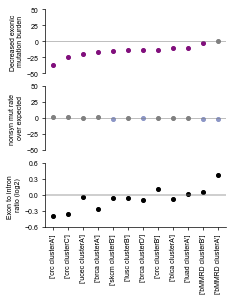

In [9]:
mut_df = pd.read_csv(path.join('results', 'mut_rate_exons_introns.tsv'), sep='\t')
decrease_df = pd.read_csv(path.join('results', 'decrease_mut_buden_exon_nonsyn.tsv'), sep='\t')

mut_df = mut_df[mut_df['total_muts'] > 500]

check = pd.merge(mut_df, decrease_df, on=['tumor_type', 'cluster'])

check['my_exin_p_adj']= mlpt(check['my_exin_p'], method='fdr_bh')[1]
check['my_synnonsyn_p_adj'] = mlpt(check['my_synnonsyn_p'], method='fdr_bh')[1]

check.sort_values(['exons_decrease_over_expected'], inplace=True)

fig = plt.figure(figsize=(3.25, 4))  # 4, 4.5

NROW=3
NCOL=1

count = 0
axs=[]
for row in range(0, NROW):
    for col in range(0, NCOL):
        axs.append(plt.subplot2grid((NROW, NCOL), (row, col)))
        
values_to_plot=[]
labels=[]
#### exon decrease over expected
cnt=1
for idx, row in check.iterrows():
    values_to_plot.append(row['exons_decrease_over_expected'])
    labels.append([row['ttype_cluster']])
    if row['exons_decrease_over_expected'] > 0: # if observed more than expected color gray
        color_to_assign = 'gray'
    elif row['exons_decrease_over_expected'] < 0 and row['my_exin_p_adj'] < 0.001:
        color_to_assign = '#810f7c'
    elif row['exons_decrease_over_expected'] < 0 and row['my_exin_p_adj'] >= 0.001:
        color_to_assign = '#8c96c6'
        
    axs[count].plot(cnt, row['exons_decrease_over_expected'],
        marker='.', linestyle='', label='', c=color_to_assign, ms = 8, )
    cnt+=1
        
axs[count].margins(0.05) # Optional, just adds 5% padding to the autoscaling

axs[count].set_facecolor('none')
axs[count].set_ylabel('Decreased exonic \n mutation burden')
axs[count].axhline(y=0, color='gray', alpha=0.5, lw=1)


for axis in ['right', 'top', 'bottom']:
     axs[count].spines[axis].set_visible(False)

axs[count].set_ylim(-50, 50)
axs[count].set_yticks([-50, -25, 0, 25, 50])
#axs[count].yaxis.set_major_locator(yticks)
axs[count].yaxis.set_ticks_position('left')
axs[count].xaxis.set_ticks_position('none')
axs[count].xaxis.set_ticks([])

count+=1

#### nonsyn decrease over expected
cnt=1
for idx, row in check.iterrows():
    if row['nonsyn_decrease_over_expected'] > 0: # if observed more than expected color gray
        color_to_assign = 'gray'
    elif row['nonsyn_decrease_over_expected'] < 0 and row['my_synnonsyn_p_adj'] < 0.001:
        color_to_assign = '#810f7c'
    elif row['nonsyn_decrease_over_expected'] < 0 and row['my_synnonsyn_p_adj'] >= 0.001:
        color_to_assign = '#8c96c6'
        
    axs[count].plot(cnt, row['nonsyn_decrease_over_expected'],
        marker='.', linestyle='', label='', c=color_to_assign, ms = 8, )
    cnt+=1

axs[count].margins(0.05)
axs[count].set_facecolor('none')
axs[count].set_ylabel('nonsyn mut rate \n over expected')
axs[count].axhline(y=0, color='gray', alpha=0.5, lw=1)

for axis in ['right', 'top', 'bottom']:
    axs[count].spines[axis].set_visible(False)

axs[count].set_ylim(-50, 50)
axs[count].set_yticks([-50, -25, 0, 25, 50])
#axs[count].yaxis.set_major_locator(yticks)
axs[count].yaxis.set_ticks_position('left')
axs[count].xaxis.set_ticks_position('none')
axs[count].xaxis.set_ticks([])

count+=1


cnt=1
for idx, row in check.iterrows():
    color_to_assign = 'black'
        
    axs[count].plot(cnt, row['log2fc_exon_intron'],
        marker='.', linestyle='', label='', c=color_to_assign, ms = 8, )
    cnt+=1

axs[count].margins(0.05)
axs[count].set_facecolor('none')
axs[count].set_ylabel('Exon to intron \n ratio (log2)')
axs[count].axhline(y=0, color='gray', alpha=0.5)

for axis in ['right', 'top']:
    axs[count].spines[axis].set_visible(False)

axs[count].set_ylim(-0.6, 0.6)
axs[count].set_yticks([-0.6, -0.3, 0, 0.3, 0.6])
#axs[count].yaxis.set_major_locator(yticks)
axs[count].yaxis.set_ticks_position('left')
axs[count].xaxis.set_ticks_position('bottom')

axs[count].set_xticks(range(1, len(labels)+1))
axs[count].set_xticklabels(labels,rotation='vertical')


count+=1


plt.savefig(path.join('figures', 'figure5A_1.svg'), bbox_inches='tight')
plt.show()

### Panel b)

Decreased exonic mutation burden of individual tumores.

blca 18 16 4
luad 25 18 4
brca 16 16 1
crc 32 27 19
lusc 44 39 8
ucec 13 13 10
skcm 31 31 19
bMMRD 4 2 2
eyelid 1 1 0


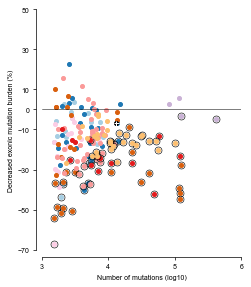

In [10]:
decrased_df = pd.read_csv(path.join('results', 'decrease_mut_buden_exon_nonsyn.tsv'), sep='\t')

clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)


fig = plt.figure(figsize=(3.5, 4))
ax = plt.subplot2grid((1, 1), (0, 0))
ax.margins(0.05)

new_labels = ['-60%', '-40%', '−20%', '0%', '20%', '40%', '60%']

# my_color_dic = {'blca':'#a6cee3', 'luad':'#1f78b4', 'brca':'#b2df8a', 'crc':'#33a02c', 'lusc':'#fb9a99',
#                 'ucec':'#e31a1c', 'skcm':'#fdbf6f', 'gbm':'#ff7f00', 'bMMRD':'#cab2d6', 'eyelid':'#d95f0e'}



my_color_dic = {'blca':'#a6cee3', 'luad':'#1f78b4', 'brca':'#fccde5', 'crc':'#d95f0e', 'lusc':'#fb9a99',
                'ucec':'#e31a1c', 'skcm':'#fdbf6f', 'gbm':'#ff7f00', 'bMMRD':'#cab2d6', 'eyelid':'black'}


for my_ttype in my_color_dic.keys():
       
    my_samples = clusters_df[clusters_df['ctype'] == my_ttype]['sample_id'].tolist()

    merged_df = pd.merge(results_per_sample_df, sub_clusters_df, on='sample')
    merged_df = merged_df[merged_df['total_muts'] > 1500]

    # subset the samples we wanted
    merged_df = merged_df[merged_df['sample'].isin(my_samples)]

    if len(merged_df) > 0:

        # adjust the p-value for multiple hypothesis testing using BH approach
        merged_df['exon_intron_p_adj']= mlpt(merged_df['exon_intron_p'], method='fdr_bh')[1]

        my_median = np.median(merged_df['exons_decrease_over_expected'])

        significant_samples_decreased = merged_df[(merged_df['exons_decrease_over_expected'] < 0)
                                                  & (merged_df['exon_intron_p_adj'] < 0.1)][['total_muts', 'exons_decrease_over_expected']]

        non_significant_samples_decreased = merged_df[(merged_df['exons_decrease_over_expected'] < 0)
                                                  & (merged_df['exon_intron_p_adj'] >= 0.1)][['total_muts', 'exons_decrease_over_expected']]

        significant_samples_increased = merged_df[(merged_df['exons_decrease_over_expected'] > 0)
                                                  & (merged_df['exon_intron_p_adj'] < 0.1)][['total_muts', 'exons_decrease_over_expected']]

        non_significant_samples_increased = merged_df[(merged_df['exons_decrease_over_expected'] > 0)
                                                  & (merged_df['exon_intron_p_adj'] >= 0.1)][['total_muts', 'exons_decrease_over_expected']]                                 

        my_grouped_samples = dict()
        my_grouped_samples['exonic_significant_decrease'] = significant_samples_decreased
        my_grouped_samples['exonic_non_significant_decrease'] = non_significant_samples_decreased
        my_grouped_samples['exonic_significant_increase'] = significant_samples_increased
        my_grouped_samples['exonic_non_significant_increase'] = non_significant_samples_increased

        # Plot
        for my_key in ['exonic_non_significant_decrease',
                       'exonic_significant_increase', 'exonic_non_significant_increase']:

            group = my_grouped_samples[my_key]

            ax.plot(np.log10(group.total_muts), group.exons_decrease_over_expected,
                    marker='.', linestyle='', label=my_key, c=my_color_dic[my_ttype], ms = 8, )
            
            
            if my_ttype == "eyelid": # add extra mark to spot
                ax.plot(np.log10(group.total_muts), group.exons_decrease_over_expected,
                    marker='+', linestyle='', label=my_key, c="white", ms = 5, )

        for my_key in ['exonic_significant_decrease']:

            group = my_grouped_samples[my_key]

            ax.plot(np.log10(group.total_muts), group.exons_decrease_over_expected,
                    marker='.', mew=0.6, linestyle='', label=my_key, mec='black', color='none', ms = 14 )


            ax.plot(np.log10(group.total_muts), group.exons_decrease_over_expected,
                   marker='.', linestyle='', label=my_key, c=my_color_dic[my_ttype], ms = 8, )
        
            print(my_ttype, len(merged_df), len(non_significant_samples_decreased) + len(significant_samples_decreased), len(significant_samples_decreased))


ax.axhline(y=0, c='black', alpha=1, linewidth=0.5)


ax.set_ylabel('Decreased exonic mutation burden (%)')
ax.set_xlabel('Number of mutations (log10)')
ax.set_facecolor('none')


for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))

ax.set_ylim(-70, 50)
ax.set_yticks([-70, -50, -30, -10, 0, 10, 30, 50])
#ax.yaxis.major.locator.set_params(nbins=8)
#ax.xaxis.major.locator.set_params(nbins=8)
ax.set_xlim(3, 6)
ax.set_xticks([3, 4, 5, 6])

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

#ax.set_yticklabels(new_labels)
plt.tight_layout()

plt.savefig(path.join('figures', 'figure5B.svg'))
plt.show()